# Social Listening Project - Anset EDA report


---




##Table of Contents


1.  Goal and Qustions
2.  Data collection
3.  Data Cleaning and Parsing
4.  EDA





## 1. Goal and Qustions


---

Our project main goal is to Know the trends of local public opinion through what is presented on social media like facebook, twitter, instagram, and others. 

So to do that we need to ask the question:
 - **What are people’s attitudes and trends about the different topics presented in terms of content (texts, images, video) and in terms of classification (social, economic, sports, etc.) on social media?**

This is a big question and to answer it we need to break it down and formulate it in other ways to be simple. We can ask:
* What is the classification of topics in social media?
* What is the most reactive content type between peoples?
* How the people interactive with economics content-for example-?
* What is the rating of the most interactive content classification by people?
* Do people care more about economics or sports topics -as example-, and why?
* And many others

When trying to answer these questions -using the collected data-; more of specific questions generated and more questions need more data collection in volume and types (this why Social Media companies collect data more and more about us! 😀)

finally, if the appropriate data is available, with good analysis and the use of AI techniques like ML & NLP, we can answer the main question and other questions that can be asked, and we can build a data application that Offers values and results to customers who are interested in knowing people's opinions and general attitudes about specific topic - or even about a specific product-.


---




## 2. Data collection


---
#### **How did we get the data**

To answer the previous questions we need data (a lot of data) so we need to collect it, but before that we need to identify the sources we want to collect from, there are many of social media application available, and collecting from them all is cumbersome, so we must identify and prioritize social media applications to get our sample from.


In Palestine, **Facebook** is the most popular soicail media apps, so there we will find the required samples, and from there we can get data that answers our questions more accurately. So to build the project prototype we will extract data from Facebook, and currently we will be collecting data from public pages specifically; because it will be easier to collect data without restrictions.

Most of Social media platforms provide APIs to access its data so we first try to use APIs provided by Facebook (Graph APIs), but there are rules and steps you should be followed to use these APIs, One is to have a truly ready-to-use app that uses the data!, so we tried other options like to find data provider or test some applications that provide data, but all of them need license (based on our search).. we found a free solutions to extract data from facebook pages but all of them depend on Web scraping techniques and we chose one of them -temporarily- until we get Facebook APIs access.

The solution is an 3rd party Python library "facebook-scraper" https://pypi.org/project/facebook-scraper/ , the library has its own bugs and problems but  it is easy to use and return a lot of structured 
 data (you can get data in CSV files or JSON object formats) which can be used easly in python code.

For example to get posted data for JawwaL Company Official page (page account id is ***Jawwal.059*** ):

In [ ]:
# First Install the libaray
!pip install -U facebook-scraper
#Or by pulling the latest version from github repository:
#pip install git+https://github.com/kevinzg/facebook-scraper.git

In [9]:

## Install Latest version of matplotlib 3.4.3 of you need to use bar_label method
# Check version
!pip install -U matplotlib

In [10]:
import facebook_scraper
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import traceback
import json
import re
import ast
import glob
import requests as req
from pandas.plotting import scatter_matrix
from IPython import get_ipython


In [ ]:
postsList = []
try:
    # use get_posts Method to get page posts and its related data
    # The next lines will get at most 300 posts (params page * posts_per_page -> 10*30).. 
    postsIttr = facebook_scraper.get_posts('Jawwal.059',  pages=3, timeout=60, extra_info=True,options={"comments": True, "reactors": True, "posts_per_page": 3})  
    #Add json to list
    for post in postsIttr:
        print("-----------Loop------------------")
        postsList.append(post)
except Exception:
    print("---------------Exception!!!------------")
    traceback.print_exc()

print(len(postsList))
#Convert list to dataframe and save it as csv file (Optional). 
#in other part of code we merge all files in csv files path into one file and dataframe
df = pd.DataFrame(postsList)
df.to_csv("Jawwal.059.csv")
df.head()


We have already collected some palestinian public pages and put them in a list,and we can make a process that take this list and make a loop to extract its data.

## 3. Data Cleaning and Parsing


---
  ### 3.1. Data Cleaning
The problem of web scraping way is that it has its own problems. and it is not the optimal solution to get data from social media applications, but we have to deal with it until we get Facebook access, or find other way. 

The coming data has many problem in data type formats and structure, so we went through the stage of data cleaning and extracting features. we even modify the source code of the library to fix some problems appeared when data processed.

Also We have other data cleaning phase as text processing prerequisite.


  ### 3.2. Data Parsing and add new features

  We have many features returned by previous process but we felt and noticed that we need more features that related to post and comments text; to make the analysis and build EDA reports, so we made a research for how we can increase features on our data, and we found that by find the classification and sentiment analysis of the post/comments text, and this need to implement NLPs features like sentiment analysis and Classification text for arabic text.. and this will take time, but Fortunately, we found ready-made tools for processing Arabic language texts that serve us in our goal.

  These tools is **arabitools** Java library (For more information: https://www.arabitools.com/). and to use it we built a web application (REST API services) that receive post/Comments texts and return classifications and sentiments for each one. This tool will be replaced when we build our solution that using machine learining techniques for classification and sentement analysis. But we will use it as a "placeholder" in the complete solution cycle.



In [54]:
# Some configuration variables that contain urls to call APIs, and classifications, 
# sentiments, and gender mapping values

# Unfortunately we need to host the api before we can use it online 

class_url = "http://localhost:8080/tools/classification"
sent_url = "http://localhost:8080/tools/sentiment"
comments_url = "http://localhost:8080/tools/comments/bulk"
posts_url = "http://localhost:8080/tools/posts/bulk"
# Path fo raw CSV files
path = r'/content/drive/MyDrive/Colab Notebooks/Report/posts'
classifications = ["sport","religions","medical","electronics_mechanics","computer_math","literatures_arts","politics_news","economics","unknown"]
sentiments = ["positive","negative","equal","bad"]
genderClass = ["male","female","uncounted"]

In [55]:
# Method that allow to load all raw CSV files in the path and combine it in one dataframe (default)
# or load one file if you specify the file name in the arguments
def load_data(fileName='ALL'):
  if(fileName=='ALL'):
    all_files = glob.glob(path + "/*.csv")
    li = []
    print(all_files)
    for filename in all_files:
      df = pd.read_csv(filename, index_col=None, header=0)
      li.append(df)

    dframe = pd.concat(li, axis=0, ignore_index=True)
  else:
    dframe = pd.read_csv(path + "/"+fileName+".csv")
    
  return dframe



>The following method used is an http client to call APIs and return Dataframe for posts and comments




In [46]:
#input
#  type: request type (posts, comments)
#  data: json data based on request type 
#Return
# Dataframe based on request type
def requestNewFeature(type, data):
  if type=="posts":
    rurl = posts_url
  else:
    rurl = comments_url

  response = req.post(rurl,
                      data=data.encode('utf-8'),
                      headers={'Content-Type': 'application/json; charset=UTF-8'})
  #print(response.json())
  outObj = response.json() # json.loads(response.json())
  if type=="posts":
    #print(outObj["posts"])
    return pd.DataFrame(outObj["posts"])
  else:
    return pd.DataFrame(outObj["comments"])  




> Load Data





In [ ]:
#To get all csv files
df = load_data()
#to get specific csv file
# df = load_data('RamallahNewsOfficialPage')
print(df.head(5))



> Send Posts texts to API to get feature



In [ ]:
allCommentsList = []
#Only Send text & post_id features
shortPostDF = df[['post_id','text']]
#Convert to JSON format
postJson = shortPostDF.to_json(orient="records",force_ascii=False)
#Call Method to call API
outshortDF = requestNewFeature("posts", postJson)
#Drop text from the result to remove duplicates text columns
outshortDF = outshortDF.drop(columns=['text'])
# merge main DF with API result
df = df.merge(outshortDF, how='left', on='post_id')
df = df.drop(columns=['Unnamed: 0'])

The previous process add classification, sentiment, and gender (for comments -actually not usefull because it cannot identify names written in non-Arabic letters -) features

The comments data apeare as one feature in posts rows (**comments_full** feature), and we need to split it and extract features for Posts from it, and the new feature will be appeared as counter features 

From Example the following features will be added to posts Dataframe that represent post's comments classification statistics

`["comment_class_sport","comment_class_religions","comment_class_medical","comment_class_electronics_mechanics","comment_class_computer_math","comment_class_literatures_arts","comment_class_politics_news","comment_class_economics","comment_class_unknown"]`

and the following for sentiment, and gender


```
Sentiments ==> ["comment_sentiments_positive","comment_sentiments_negative","comment_sentiments_equal","comment_sentiments_bad"]
Gender ==> ["commenter_gender_male","commenter_gender_female","commenter_gender_uncounted"]
```



> The following Method take the result from comment API call and generate the new features:






In [6]:
def addExtractedCommentsFeaturesToPost(postID,postDF,postCommentsDF):    
    classifCounts = postCommentsDF['classification'].value_counts(dropna=False)
    sentimCounts = postCommentsDF['sentiment'].value_counts(dropna=False)
    # Classification 
    for classVal in classifications:
        if classVal in classifCounts: 
            postDF.loc[postDF.post_id == postID, 'comment_class_'+classVal] = classifCounts[classVal]
        else:
            postDF.loc[postDF.post_id == postID, 'comment_class_'+classVal] = 0
    # Sentiments
    for sentVal in sentiments:
        if sentVal in sentimCounts:
             postDF.loc[postDF.post_id == postID, 'comment_sentiments_'+sentVal] = sentimCounts[sentVal]
        else:
             postDF.loc[postDF.post_id == postID, 'comment_sentiments_'+sentVal] = 0
    # gender fields
    for genderVal in genderClass:
        if genderVal in sentimCounts:
             postDF.loc[postDF.post_id == postID, 'commenter_gender_'+genderVal] = sentimCounts[sentVal]
        else:
             postDF.loc[postDF.post_id == postID, 'commenter_gender_'+genderVal] = 0   


In [ ]:
number_of_rows = len(df.index)
print("Number Of Rows: "+number_of_rows)

for i in range(number_of_rows):
  if not pd.isnull(df.loc[i]['comments_full']):
      try:
          commentsStr = df.loc[i]['comments_full']
          commentObj = eval(commentsStr)
          postCommentsDF = pd.DataFrame(commentObj)
          if len(postCommentsDF) > 0:
              postCommentsDF = postCommentsDF.rename(columns={"comment_text": "text"})
              shortCommDF = postCommentsDF[['comment_id','commenter_name', 'text','comment_time']]
              commentJson = shortCommDF.to_json(orient="records",force_ascii=False)
              postCommentsDF = requestNewFeature("comments", commentJson)
              addExtractedCommentsFeaturesToPost(df.loc[i]['post_id'], df,postCommentsDF)
              postCommentsDF["post_id"] = df.loc[i]['post_id']
              allCommentsList.append(postCommentsDF)
      except Exception:
          print("----------------Exception -----------------------")
          print("----------------Post Id ----------------------- "+ str(df.loc[i]['post_id']) )
          traceback.print_exc()
          #break;



> Now the Post Dataframe contain the required features, for analysis purpose and to separate the stages we will save the posts dataframe (df) as a csv file **processed_posts.csv**, also We have collected all the comments in one datafram (after add post id to it ) for future use



In [ ]:
df.to_csv('processed_posts.csv', index=False)
allcommentsDF = pd.concat(allCommentsList, axis=0, ignore_index=True)
allcommentsDF.to_csv('all_posts_comment_proc.csv', index=False)



---



## 4. EDA


---

In the previous steps we generate 2 CSV files and in this section we are going to analyze the posts dataframe (file: processed_posts.csv) and try to find correlations between features. For EDA we need second phase of text cleaning.

In [ ]:
!pip install wordcloud 
!pip install arabic-reshaper
!pip install python-bidi
!pip install cufflinks

In [1]:
import warnings
warnings.filterwarnings("ignore");

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import os
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import f1_score

import re
import string
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
import sklearn 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 



In [3]:
# Load CSV file to analyze
df = pd.read_csv("processed_posts.csv")
    #load_data(fileName="processed_posts")
df.head()

,post_id,text,post_text,shared_text,time,timestamp,image,image_lowquality,images,images_description,...,comment_class_politics_news,comment_class_economics,comment_class_unknown,comment_sentiments_positive,comment_sentiments_negative,comment_sentiments_equal,comment_sentiments_bad,commenter_gender_male,commenter_gender_female,commenter_gender_uncounted
0,4476048722430260,ورشة فنّيّة الطباعة الزّرقاء (Cyanotype) مع ال...,ورشة فنّيّة الطباعة الزّرقاء (Cyanotype) مع ال...,"THU, NOV 11 AT 12:30 PM UTC+02\nورشة فنّيّة ال...",2021-11-09 13:11:19,1.636456e+09,https://scontent.fjrs2-2.fna.fbcdn.net/v/t1.64...,https://external.fjrs2-2.fna.fbcdn.net/safe_im...,['https://scontent.fjrs2-2.fna.fbcdn.net/v/t1....,[],...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4475880899113709,حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...,حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...,NaN,2021-11-09 11:51:59,1.636452e+09,https://scontent.fjrs2-2.fna.fbcdn.net/v/t1.64...,https://scontent.fjrs2-2.fna.fbcdn.net/v/t1.64...,['https://scontent.fjrs2-2.fna.fbcdn.net/v/t1....,"['May be an image of 4 people, people standing...",...,16.0,0.0,0.0,5.0,0.0,11.0,0.0,0.0,0.0,0.0
2,4473815812653551,"كتب خريج الجامعة المهندس وجدي مرعب ""ما زلت أذك...","كتب خريج الجامعة المهندس وجدي مرعب ""ما زلت أذك...",NaN,2021-11-08 18:06:49,1.636388e+09,https://scontent.fjrs2-2.fna.fbcdn.net/v/t39.3...,https://scontent.fjrs2-2.fna.fbcdn.net/v/t39.3...,['https://scontent.fjrs2-2.fna.fbcdn.net/v/t39...,['May be an image of \u200eone or more people ...,...,8.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
3,4472684389433360,"من الفعاليات الفلكية في مرصد الجامعة الفلكي ""م...","من الفعاليات الفلكية في مرصد الجامعة الفلكي ""م...",NaN,2021-11-08 10:23:53,1.636360e+09,https://scontent.fjrs2-2.fna.fbcdn.net/v/t39.3...,https://scontent.fjrs2-2.fna.fbcdn.net/v/t39.3...,['https://scontent.fjrs2-2.fna.fbcdn.net/v/t39...,"['May be an image of one or more people, peopl...",...,13.0,0.0,0.0,4.0,0.0,9.0,0.0,0.0,0.0,0.0
4,4467398659961933,جامعة بيرزيت تفوز بدعم مشروعين من الوكالة النر...,جامعة بيرزيت تفوز بدعم مشروعين من الوكالة النر...,BIRZEIT.EDU\nجامعة بيرزيت تفوز بدعم مشروعين من...,2021-11-06 15:43:52,1.636206e+09,https://www.birzeit.edu/sites/default/files/dj...,https://external.fjrs2-2.fna.fbcdn.net/safe_im...,['https://www.birzeit.edu/sites/default/files/...,[],...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0




> Now We need to drop some unused features



In [4]:
# mimmize Dataframe 
df['post_text_length'] =  df['text'].str.len()
df['has_image'] = np.where(df['image'].isnull(), 0, 1 )
df['has_video'] = np.where(df['video'].isnull(), 0, 1 )

sdf = df[['post_id', 'text', 'time','has_image','has_video','is_live','likes',
             'comments','shares','post_text_length','sentiment','classification',
             'sentiment_percentage','comment_class_sport','comment_class_religions',
             'comment_class_medical','comment_class_electronics_mechanics',
             'comment_class_computer_math','comment_class_literatures_arts',
             'comment_class_politics_news','comment_class_economics',
             'comment_class_unknown','comment_sentiments_positive','comment_sentiments_negative',
             'comment_sentiments_equal','comment_sentiments_bad']]
sdf.head()

,post_id,text,time,has_image,has_video,is_live,likes,comments,shares,post_text_length,...,comment_class_electronics_mechanics,comment_class_computer_math,comment_class_literatures_arts,comment_class_politics_news,comment_class_economics,comment_class_unknown,comment_sentiments_positive,comment_sentiments_negative,comment_sentiments_equal,comment_sentiments_bad
0,4476048722430260,ورشة فنّيّة الطباعة الزّرقاء (Cyanotype) مع ال...,2021-11-09 13:11:19,1,0,False,0.0,1,0,244.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4475880899113709,حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...,2021-11-09 11:51:59,1,0,False,133.0,17,1,138.0,...,0.0,0.0,0.0,16.0,0.0,0.0,5.0,0.0,11.0,0.0
2,4473815812653551,"كتب خريج الجامعة المهندس وجدي مرعب ""ما زلت أذك...",2021-11-08 18:06:49,1,0,False,87.0,8,3,646.0,...,0.0,0.0,0.0,8.0,0.0,0.0,3.0,0.0,5.0,0.0
3,4472684389433360,"من الفعاليات الفلكية في مرصد الجامعة الفلكي ""م...",2021-11-08 10:23:53,1,0,False,109.0,13,3,150.0,...,0.0,0.0,0.0,13.0,0.0,0.0,4.0,0.0,9.0,0.0
4,4467398659961933,جامعة بيرزيت تفوز بدعم مشروعين من الوكالة النر...,2021-11-06 15:43:52,1,0,False,126.0,1,2,230.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   post_id                              3654 non-null   int64  
 1   text                                 3604 non-null   object 
 2   time                                 3654 non-null   object 
 3   has_image                            3654 non-null   int32  
 4   has_video                            3654 non-null   int32  
 5   is_live                              3654 non-null   bool   
 6   likes                                3651 non-null   float64
 7   comments                             3654 non-null   int64  
 8   shares                               3654 non-null   int64  
 9   post_text_length                     3604 non-null   float64
 10  sentiment                            3604 non-null   object 
 11  classification                

### 4.1. Classifications and sentiment
We need to check and find the correlations and insights from our data based on classifications and sentiments, we may can answer questions like, from collected data what is the most classification exists, Or what people feel when interactive with economics content.

Here we will ask the questions and then answer it through what we get out of the dataset and charts

In [6]:
sdf.groupby(['classification'])['classification'].value_counts()

classification                       classification                     
computer_math,politics_news          computer_math,politics_news               1
computer_math,unknown,politics_news  computer_math,unknown,politics_news       1
politics_news                        politics_news                          3495
politics_news,computer_math          politics_news,computer_math             107
Name: classification, dtype: int64

In [11]:
#init Chart params
sns.set(color_codes=True)
sns.set_theme(style="darkgrid")
interactionParams = ['likes','comments','shares']

## Install Latest version of matplotlib 3.4.3 of you need to use bar_label method
# Check version
print(mpl.__version__)

3.4.3


**- What is the order of the contents classifications in terms of frquency (count) in the data**


---





[Text(0, 0, '3604'), Text(0, 0, '109'), Text(0, 0, '1')]

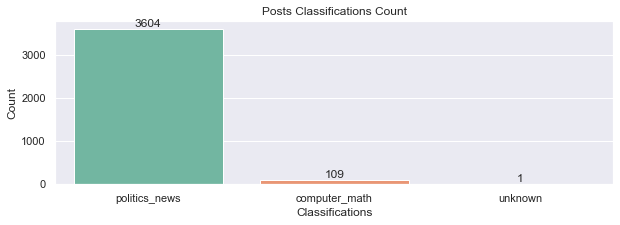

In [13]:
f, ax = plt.subplots(1,1, figsize=(10, 3));
plt.figure(1)
# The get classification API may return multible categories for the same text,
# So here we will split these multible values if exists and crea1te new row for each one
postCountPlotDF = sdf.loc[:, ['post_id','sentiment','likes','comments','shares','post_text_length']]
postCountPlotDF['classification'] = sdf['classification'].str.split(',')
postClassiPlotDF = postCountPlotDF.explode('classification').reset_index(drop=True)
#draw count bar plot
ax = sns.countplot(x="classification", data=postClassiPlotDF, color="c", palette="Set2",
                   order=postClassiPlotDF['classification'].value_counts(ascending=False).index);
plt.title('Posts Classifications Count')
plt.xlabel('Classifications')
plt.ylabel('Count')
count_values = postClassiPlotDF['classification'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=count_values)


We found that the politics news classification have the maximum value then ecomnomics..

---



**- What is the order of the contents sentement (based on post text not comments) in terms of frquency (count) in the data**


---





[Text(0, 0, '1547'), Text(0, 0, '1394'), Text(0, 0, '547'), Text(0, 0, '116')]

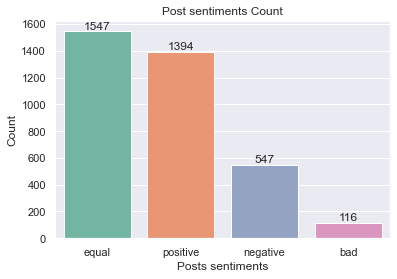

In [14]:
plt.figure(2)
ax = sns.countplot(x="sentiment", data=postCountPlotDF, color="c", palette="Set2",
              order=postCountPlotDF['sentiment'].value_counts(ascending=False).index);

plt.title('Post sentiments Count')
plt.xlabel('Posts sentiments')
plt.ylabel('Count')
count_values = postCountPlotDF['sentiment'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=count_values)

Most of the contents (posts text) is moderate -Equal-, neither negative nor positive, and this is logical in relation to the nature of the pages chosen for this sample, which are news pages..
 
But we noticed that there are some "bad" posts text which is texts that contain insults or bad words, but when take some sample of bad posts we didn't find the reason why it was counted bad post by the tools, Here we began to doubt the tool used for analysis and we need to check more available tools (or built one in the future)


---



**- How is the relation between post classifications and sentiments?**

---



Following table contain unique counts betwee Classifcations and sentiments.

In [15]:

sentClassiDF = postClassiPlotDF.drop(columns=['post_id'])
unqCountsDF =sentClassiDF.groupby(['classification','sentiment']).classification.agg([('count', 'count')]).reset_index()

# Print table
unqCountsDF.head(20)


,classification,sentiment,count
0,computer_math,bad,2
1,computer_math,equal,54
2,computer_math,negative,14
3,computer_math,positive,39
4,politics_news,bad,116
5,politics_news,equal,1547
6,politics_news,negative,547
7,politics_news,positive,1394
8,unknown,equal,1


Text(0.5, 1.0, 'Posts sentiments vs classification')

<Figure size 432x288 with 0 Axes>

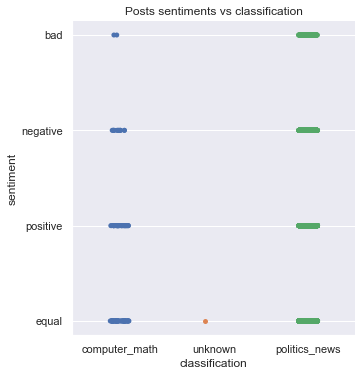

In [16]:
plt.figure(3)
ax = sns.catplot(x="classification", y="sentiment", data=postClassiPlotDF, kind="strip")
plt.title('Posts sentiments vs classification')

<Figure size 432x288 with 0 Axes>

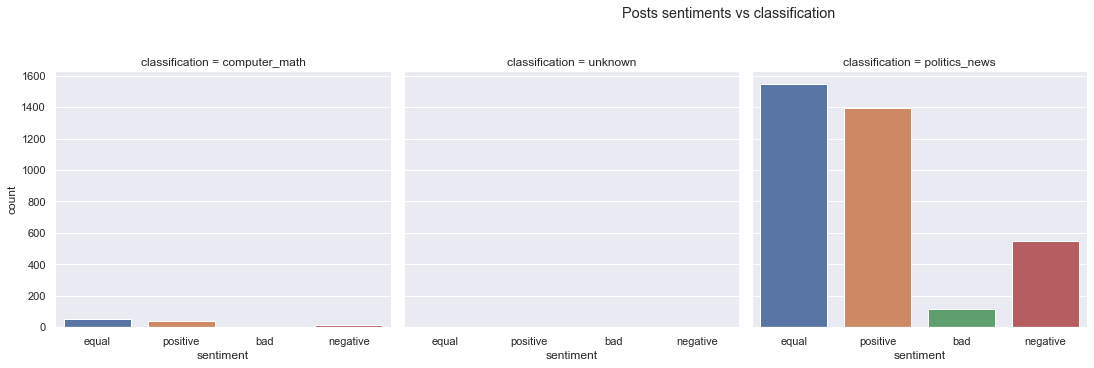

In [17]:
f = plt.figure(4)
ax = sns.catplot(x="sentiment", col="classification", data=postClassiPlotDF, kind="count", col_wrap=4)
#f.suptitle("Posts sentiments vs classification")
ax.fig.suptitle("Posts sentiments vs classification")
ax.fig.subplots_adjust(top=.8)

The charts show the sentiments count for each class (Category)


---



### 4.2. Interactions (likes, comments, share, ..etc)

In this section we will check Posts interactions correlations 

**- What is the relation between likes, comments, shares counts with the posts classifications and sentiments?**

---------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

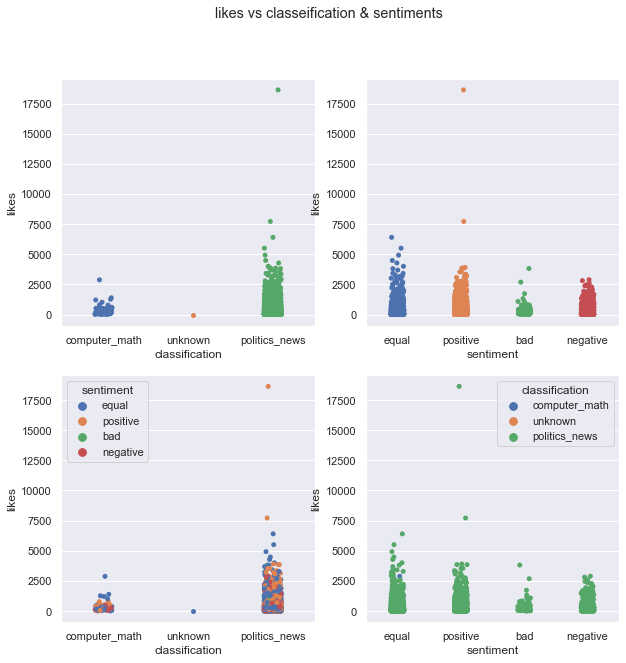

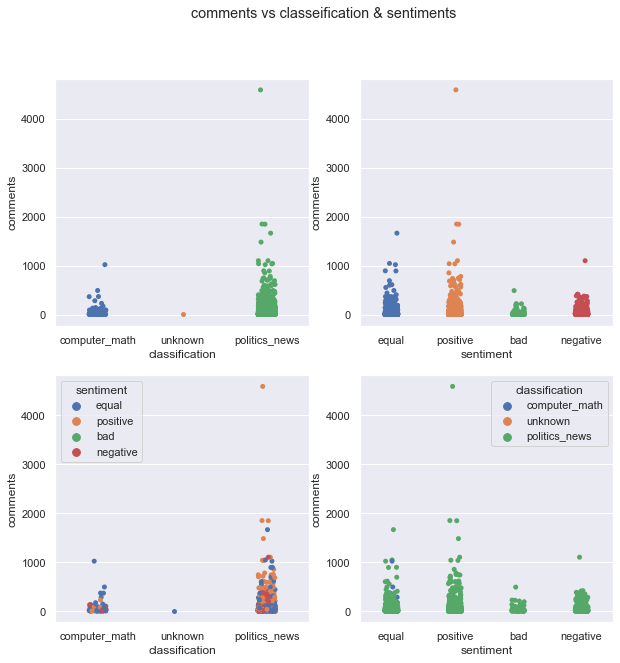

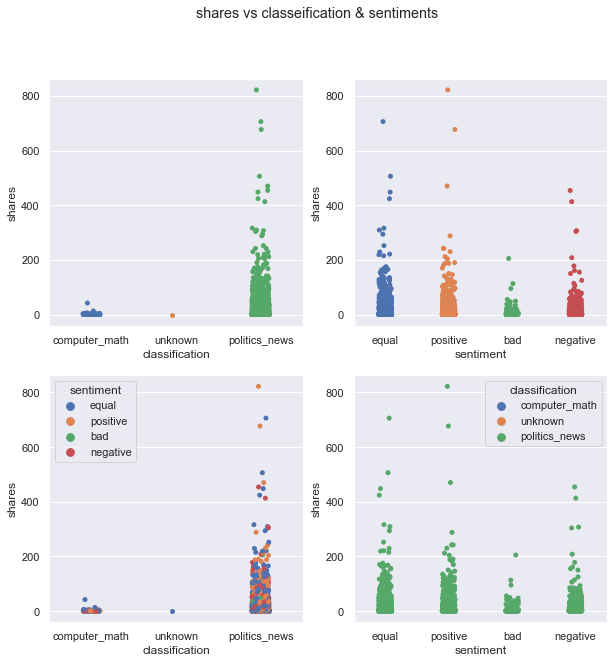

In [18]:
fixIndex = 5
print("---------------------------------------------------------------------")
for param in interactionParams:
    plt.figure(fixIndex)
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    fig.suptitle(param+' vs classeification & sentiments ')
    
    #print(df['video'].dropna().notna())
    sns.stripplot(x="classification", y=param, data=postClassiPlotDF,  ax=axes[0][0])
    sns.stripplot(x="sentiment", y=param,  data=df,  ax=axes[0][1])
    sns.stripplot(x="classification", y=param, hue="sentiment", data=postClassiPlotDF,  ax=axes[1][0])
    sns.stripplot(x="sentiment", y=param,  data=postClassiPlotDF,  hue="classification", ax=axes[1][1])
    fixIndex+=1

the previous charts show the interactions parameters against classifications and sentiment, the relation is not clear here but so we need to check comments classifications and sentiments against interactions parameters.


---



**- What is the relation between post's text length with the posts classifications and sentiments?**


---



<Figure size 432x288 with 0 Axes>

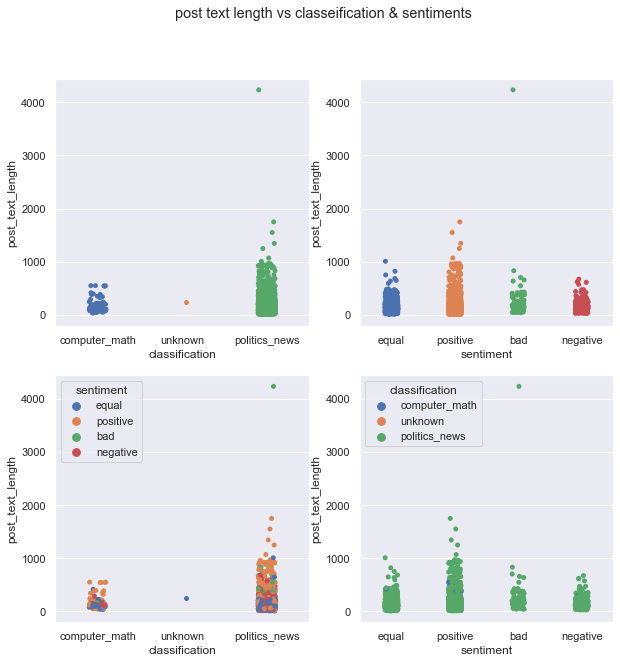

In [21]:
    plt.figure(fixIndex)
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    fig.suptitle('post text length vs classeification & sentiments ')
    
    #print(df['video'].dropna().notna())
    sns.stripplot(x="classification", y='post_text_length', data=postClassiPlotDF,  ax=axes[0][0])
    sns.stripplot(x="sentiment", y='post_text_length',  data=sdf,  ax=axes[0][1])
    sns.stripplot(x="classification", y='post_text_length', hue="sentiment", data=postClassiPlotDF,  ax=axes[1][0])
    sns.stripplot(x="sentiment", y='post_text_length',  data=postClassiPlotDF,  hue="classification", ax=axes[1][1])
    fixIndex+=1

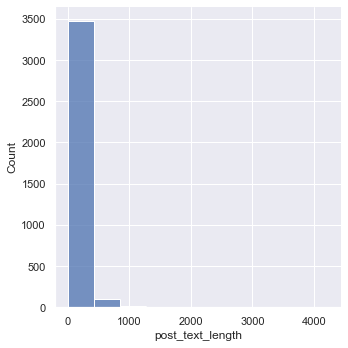

In [22]:

ax = sns.displot(sdf.post_text_length, kde=False, bins=10)


Her most of posts in deferent classes or sentiments are less than 200 charachters. But most of the long  texts are for politics.

---



**- How does post text length affect interaction**

---



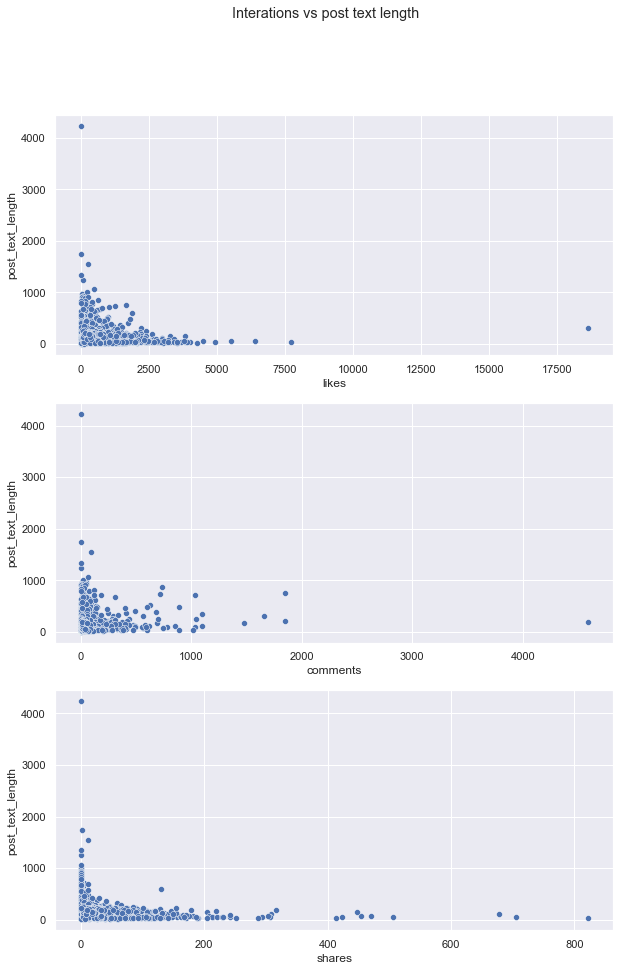

In [23]:
    fig, axes = plt.subplots(3,1, figsize=(10, 15))
    fig.suptitle('Interations vs post text length')
    sns.scatterplot(x="likes", y="post_text_length", data=sdf,  ax=axes[0])
    sns.scatterplot(x="comments", y="post_text_length", data=sdf, ax=axes[1])
    sns.scatterplot(x="shares", y="post_text_length", data=sdf,  ax=axes[2])

    fixIndex+=1

The figures tells us that shorter texts have more interactions

---



**- How does using media like images and vedios affect interaction?**

---



In [24]:
print('Number of Posts: {}'.format(len(sdf)))
print('Number of Posts With images Medai: {}'.format(len(sdf[sdf['has_image'] == 1])))
print('Number of Posts Without images Medai: {}'.format(len(sdf[sdf['has_image'] == 0])))
print('Number of Posts With video Medai: {}'.format(len(sdf[sdf['has_video'] == 1])))
print('Number of Posts Without video Medai: {}'.format(len(sdf[sdf['has_video'] == 0])))
print('Number of Posts Without Images and video: {}'.format(len(sdf[(sdf['has_video'] == 0) & (sdf['has_image'] == 0)])))
perst = (len(sdf[(sdf['has_video'] == 0) & (sdf['has_image'] == 0)]) / len(sdf))*100
print('post that dont have medai percentage: {}% '.format(round(perst, 2)))


Number of Posts: 3654
Number of Posts With images Medai: 2969
Number of Posts Without images Medai: 685
Number of Posts With video Medai: 502
Number of Posts Without video Medai: 3152
Number of Posts Without Images and video: 183
post that dont have medai percentage: 5.01% 


Posts Have Images percentage:

In [25]:
value_countssr = sdf['has_image'].value_counts(normalize=True) * 100
df_val_counts = pd.DataFrame(value_countssr)
df_value_counts_reset = df_val_counts.reset_index()
df_value_counts_reset.columns = ['has_image', 'percentage']
df_value_counts_reset['has_image'] = df_value_counts_reset['has_image'].apply(str).replace({"1": "Yes", "0": "No"})
df_value_counts_reset.head()

,has_image,percentage
0,Yes,81.253421
1,No,18.746579


Posts Have videos percentage:

In [26]:
value_countssr = sdf['has_video'].value_counts(normalize=True) * 100
df_val_counts = pd.DataFrame(value_countssr)
df_value_counts_reset = df_val_counts.reset_index()
df_value_counts_reset.columns = ['has_video', 'percentage']
df_value_counts_reset['has_video'] = df_value_counts_reset['has_video'].apply(str).replace({"1": "Yes", "0": "No"})
df_value_counts_reset.head()

,has_video,percentage
0,No,86.261631
1,Yes,13.738369


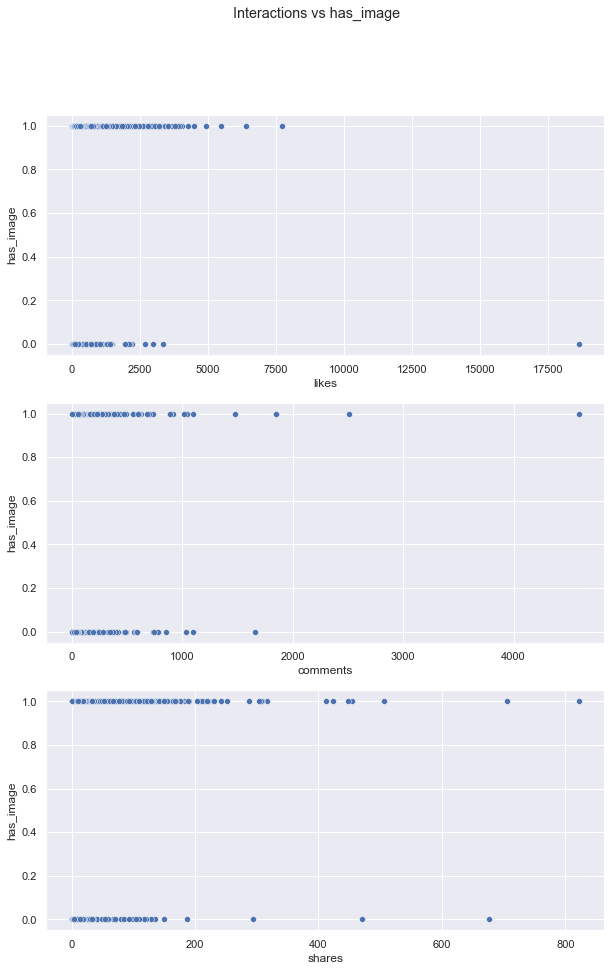

In [28]:
#sns.relplot(x="likes", y="has_image",  data=sdf);
fig, axes = plt.subplots(3,1, figsize=(10, 15))
fig.suptitle('Interactions vs has_image')
sns.scatterplot(x="likes", y="has_image", data=sdf,  ax=axes[0])
sns.scatterplot(x="comments", y="has_image", data=sdf, ax=axes[1])
sns.scatterplot(x="shares", y="has_image", data=sdf,  ax=axes[2])

fixIndex+=1



---


**- Actually there are a lot of question we can ask about the data and features relations so we Apply pairplot here**

---
And we will continue to find relationships and analyze the data we get


In [31]:
plt.figure(fixIndex)
sns.pairplot(data=sdf.drop(columns=['post_id','sentiment_percentage','is_live']))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Text processing

---


Take only text and other related feature that may need to classify and analyze text, also we need to clean the text for NLP and Text processiing.

Notes: we add sentiment, and classification features to explore what we may need and to test methods to build  sentiment, and classification models at the end

In [34]:
txtdf = sdf[['post_id', 'text','sentiment','classification']]
txtdf.dropna(subset=['text'])
# remove null text
txtdf = txtdf[~txtdf['text'].isnull()]
print(txtdf.isna().sum())
txtdf.dropna()
print(txtdf.isna().sum())


print(txtdf.shape)

txtdf["classification"] = txtdf["classification"].str.split(',').str[0]

txtdf.head(12)

post_id           0
text              0
sentiment         0
classification    0
dtype: int64
post_id           0
text              0
sentiment         0
classification    0
dtype: int64
(3604, 4)


,post_id,text,sentiment,classification
0,4476048722430260,ورشة فنّيّة الطباعة الزّرقاء (Cyanotype) مع ال...,equal,computer_math
1,4475880899113709,حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...,positive,computer_math
2,4473815812653551,"كتب خريج الجامعة المهندس وجدي مرعب ""ما زلت أذك...",positive,politics_news
3,4472684389433360,"من الفعاليات الفلكية في مرصد الجامعة الفلكي ""م...",equal,politics_news
4,4467398659961933,جامعة بيرزيت تفوز بدعم مشروعين من الوكالة النر...,positive,politics_news
5,4466792616689204,تنعى جامعة بيرزيت ممثلة برئيسها وهيئاتها الأكا...,positive,politics_news
6,4466732473361885,اعتقلت قوات الاحتلال الإسرائيلي فجر اليوم الطا...,equal,politics_news
7,4460185397349926,"خريجو جامعة بيرزيت يشاركون أهالي بلدة ""بيتا"" ق...",equal,politics_news
8,4457548814280251,تسلم رئيس دائرة الجغرافيا د. محمد كتانة كتاب ا...,bad,politics_news
9,4454513374583795,جانب من الوقفة التي نظمتها الحركة الطلابية في ...,positive,politics_news


#### Stopwords list that will be used to remove it from text, we can also depend on the predefined stopwords defined in library we are using, also we need to define palestinian dialect stop words

In [36]:
mystop = ['مثلا', 'الحمدلله', 'السنه', 'صوت', 'بو', 'تشوف',
 'موضوع', 'فتره', 'بعيد', 'الصوره', 'ابدا', 'الحب', 'الحمد', 'معاهم', 'قلبك', 'وانتي', 'لحد', 'واحنا', 'عمرك',
 'الحياه', 'امين', 'ابن', 'اخوي', 'مني', 'اسمه', 'ياخي', 'باقي', 'انتوا', 'حب', 'عندكم', 'شغل', 'كلامك', 'يسعد', 'تبي',
 'مبروك', 'طلعت', 'شلون', 'تعرف', 'كثر', 'بلا', 'وبعدين', 'عام', 'عيب', 'رمضان', 'البيت', 'نص', 'جديد',
 'ثاني', 'عارفه', 'فلوس', 'الصبح', 'الاول', 'شيء', 'صوره', 'فقط', 'وفي', 'جاي', 'جماعه', 'بن', 'خلص', 'وان', 'شعب',
 'واضح', 'تحت', 'طب', 'يلا', 'واذا', 'صارت', 'عنه', 'ضد', 'ماشي', 'لسه', 'يبي', 'بخير', 'روح',
 'حبيبي', 'سنين', 'كثير', 'زين', 'شوف', 'دايما', 'بكره', 'يجي', 'كلنا', 'الوقت', 'يبارك', 'اهم', 'معاه', 'مشكله',
 'الكويت', 'اشوف', 'فكره', 'لين', 'انهم', 'مكان', 'حرام', 'لله', 'يطلع', 'اعرف', 'افضل', 'صحيح', 'فوق', 'ترى',
 'اه', 'بعدين', 'المفروض', 'كبير','شكرا', 'تاني','ايه','احنا','وين','ليش','شو','الا', 'شفت', 'غلط', 'للاسف', 'تويتر',
 'نفسك', 'ساعه', 'معك', 'البلد', 'بنت', 'محد','اهل', 'معاك', 'نفسه', 'اشي', 'ايش', 'المهم', 'بقى', 'انتو', 'مافي', 'منو',
 'عاد', 'كلمه', 'اكبر', 'كلهم', 'والا', 'نفسي', 'المشكله', 'اقول', 'ايام', 'قاعد', 'يلي', 'زمان', 'الكل', 'انها', 'محمد',
 'ام', 'طلع', 'بكل', 'شويه', 'تقول', 'عليكم', 'الواحد', 'صباح', 'قلت', 'خلاص', 'يصير', 'الموضوع', 'عندهم', 'العالم',
 'الدنيا', 'الشعب', 'طبعا', 'طول', 'رب', 'الخير', 'اما', 'حلو', 'فعلا', 'مب', 'شوي', 'احد', 'وكل', 'وقت', 'فيهم', 'منك',
 'شخص', 'قلبي', 'الكلام', 'عارف', 'منهم', 'اخر', 'كلها', 'هاي', 'حلوه', 'اكتر', 'يمكن', 'تكون', 'لانه', 'واللي', 'كلام',
 'الحين', 'احلى', 'علشان', 'عندنا', 'بالله', 'الف', 'عندك', 'احسن', 'قطر', 'وحده', 'علينا', 'بدون', 'عنده', 'يقول', 'عادي',
 'كله', 'عليها', 'دا', 'حق', 'ابو', 'عليهم', 'اصلا', 'فيك', 'مصر', 'اكيد', 'اللى', 'كتير', 'رح', 'ربنا', 'كمان',
 'ليه', 'لان', 'اكثر', 'ال', 'وانت', 'انتي', 'طيب','سنه', 'كده', 'نفس', 'عندي', 'هيك','خير','صح','مين','شاء','مثل',
 'انو','زي','صار','انك','عم','ربي','يارب','حاجه','كنت','اليوم','اني','اول','ممكن','مره','دي','وانا','ناس','راح','حد',
 'لازم','يوم','ده','مو','علي','واحد','اي','الناس','يعني','عشان','اذا','انت','شي','هه','والله','مش','انا','الله','اللي',
 'الجديد', 'عالم', 'طريقه', 'تونس', 'كفايه', 'ارجع', 'التغريده', 'الاخر', 'السبب', 'حسن', 'صعبه', 'راسك', 'تحكي', 'عبد', 'لمن', 'عني',
 'والناس', 'عيونك', 'للناس', 'الصراحه', 'داخل', 'الامارات', 'رقم', 'العام', 'امريكا', 'حصل', 'خايف', 'لبنان', 'يتكلم', 'فرق', 'غريب',
 'العربيه', 'ماشاء', 'رغم', 'علاقه', 'يرحمه', 'الهلال', 'خلك', 'فيديو', 'مبارك', 'موجوده', 'ساعات', 'انته', 'لينا', 'المباراه', 'مافيه', 'ماراح',
 'شعور', 'ترجع', 'للحين', 'باي', 'شايف', 'باب', 'تميم', 'مدري', 'جاب', 'ولما', 'صاحب', 'يسلمك', 'صرت', 'الوطن', 'تانيه', 'الجيش',
 'يرجع', 'يحفظك', 'يعمل', 'لقيت', 'يرحم', 'صدق', 'الموسم', 'خالد', 'اهو', 'الفلوس', 'اغلب', 'وكان', 'اسبوع', 'اخي', 'قصه', 'الاقل',
 'هالشي', 'اغنيه', 'يستر', 'يابو', 'سنوات', 'عين', 'اسمع', 'يومين', 'بالضبط', 'مرات', 'كاس', 'كانو', 'خاصه', 'رجل', 'تستاهل', 'بعدها',
 'قادر', 'يخليك', 'امه', 'وربي', 'صور', 'نعرف', 'راه', 'اقسم', 'طيبه', 'الوحيد', 'بتكون', 'عيال','لاني', 'ياخذ',
 'بسرعه', 'رايح', 'امك', 'تقدر', 'تو', 'جديده', 'مساء', 'برضو', 'راسي', 'كفو', 'جمهور', 'مجرد', 'قاعده', 'مهم', 'ريال', 'غالي', 'اعمل',
 'الشيخ', 'شاءالله', 'برا', 'صلاح', 'الحلوه', 'صباحك', 'الدين', 'اروح', 'بكون', 'عيد', 'بلاش', 'عرفت', 'معانا', 'اسمها', 'النوم', 'يلعب',
 'شر', 'راس', 'خبر', 'ادري', 'الرجال', 'غيره', 'عايشين', 'وهم', 'واحده', 'شباب', 'فاهم', 'حالك', 'دور', 'اتمنى', 'حالي', 'الفيديو', 'بشكل',
 'بالعكس', 'حسب', 'كامل', 'وجه', 'كويس', 'يستاهل', 'ليبيا', 'الشارع', 'جو', 'قوي', 'الطيب', 'نقول', 'غيرك', 'ابي', 'عنها', 'قريب', 'بكرا',
 'تسلم', 'قالت', 'تعال', 'عارفين', 'تروح', 'راحت', 'فيني', 'حل', 'اقل', 'منكم', 'تجي', 'دام', 'بحب', 'بيكون', 'الليل', 'مباراه', 'الثاني',
 'الوكيل', 'عايش', 'روحي', 'الارض', 'بلد', 'بسبب', 'ايران', 'معه', 'حاليا', 'فيكم', 'تقريبا', 'الاهلي', 'الشخص', 'العين', 'دخل', 'يشوف',
 'فريق', 'ياريت', 'سبب', 'شكلك', 'العرب', 'مال', 'الفريق', 'ودي', 'يقدر', 'ماهو', 'بدل', 'يروح', 'بنات', 'بالي', 'قول', 'الجو', 'نبي', 'عمر',
 'رئيس', 'اختي', 'اكل', 'دكتور', 'تصير', 'رد', 'احس', 'العمر', 'امس', 'حال', 'ورا', 'وعلى', 'بقي', 'اجمل', 'عيني', 'صعب', 'شن', 'وهي',
 'وبس', 'كانوا', 'الدوله', 'صراحه', 'باذن', 'يبقى', 'كبيره', 'اعتقد', 'الشي', 'للي', 'اسم', 'صاير', 'ثانيه', 'نشوف', 'بالنسبه', 'سؤال', 'الحق',
 'كنا', 'لكل', 'ماله', 'يقولون', 'انسان', 'بالك', 'جميل', 'مستحيل', 'الساعه', 'حياتي', 'احب', 'اساس', 'الان', 'الوضع', 'عمل', 'ولد', 'البنات',
 'بصراحه', 'عنك', 'رجال', 'فين', 'يالله', 'الشباب', 'الايام', 'بلوك', 'تطلع', 'اتوقع', 'طبيعي', 'امي', 'قدام', 'ونعم', 'الحكومه', 'بيت', 'خل',
 'حساب', 'القلب', 'شهر', 'بعرف', 'احمد', 'حبيبتي', 'انتم', 'جد', 'حاله', 'البنت', 'حتي', 'عمره', 'موجود', 'فينا', 'اللهم', 'حسبي', 'يعرف',
 'بجد', 'عمري', 'العيد', 'عليا', 'معي', 'شكله', 'قلب',
 'شوفي','شفته','وانتم','يوصل','خصوصا','وبين','لعبه','المسلسل','نوع','الحلقه','وحتى','اى','اش',
 'عايشه','سعد','انشالله','كره','المكان','شهور','هديه','حلقه',
 'اكتب','فاهمه','صغيره','كون','قالو','الملعب','هدف','البحر','الاولى',
 'معروف','اقوى','تجيب','يضحك','خاطر','الصحه','واقف','مجلس','لحظه',
 'حبيب','السالفه','الشوق','دخلت','ومع','العربي','مصر',
 'روحك','بيهم', 'بتقول','يدخل','مسكين','فيلم','الثانيه','معناها',
 'عمان','العراق','ياارب','افهم','الفكره','تغريده','بال',
 'دقايق','اننا','الروح','حمار','شاف','الدول','يعطيك',
 'تركيا','معاكم','تدخل','الورد','نور','طويل','تركي',
 'شغله','جميع','خساره','وقتها','الكلب','بالخير','الغلط','قيمه','جمال','اجل','تمام','قليل',
 'ضروري','الطريق','معنا','المصري','قالك','تغير',
 'السؤال','بعده','بيقول','سلام','تعمل',
 'عز','اولا','ترامب','ليله','بره','تسوي','الفرق','دايم',
 'احبك','بالف','السياره','ماكو','تمشي',
 'الجاي','ثوره','احساس','يرد','وخلاص','مشاكل','ينزل','الباب','لانهم',
 'قويه','الحكم','حمد','نعمه','معاها','هاذي','جنب','عبدالله','قصدي',
 'الاكل','ثلاث','الانسان','قهوه','تدري','ايوه','وبعدها','مفروض','القصه','وجهه','الجامعه','غصب','الحلو','امل','الفيس','جايه',
 'يمشي','بدري','الحل','خاص','جيت','سوريا','لسانك','كلامي',
 'رحت','نزل','يسعدك','ونص','علم','المره','الك',
 'نفسهم','السلام','اشياء','الحال','حط','بصير','توصل', 'برنامج','يعنى','مثلك','بدايه','العظيم','قالوا','الغالي',
 'قوه','عيوني','حياتك','شخصيه','عمي','وسط','والي','طال',
 'لانها','اجازه','المغرب','عامل','سعيد','الصح','دقيقه','استاذ',
 'يلعن','غريبه', 'عربي','شئ','دليل','انكم','بينا',
 'شكل','معلش','مبرووك','تحس','يقولك','يحب','مدرب','العافيه','الحقيقه','مالها','نسيت','عدل',
 'دم','سمعت','خالص','وجهك','بنفس','اطلع','معقول','فرصه',
 'خليك','مات','ولاد','البشر','مسلسل','طريق','دائما',
 'اكون','ويا','يوفقك','حي','حياه',
 'عنهم','رايك','معاي','صغير','تتكلم','هوا','نفسها','ديما','كميه','قدر','حبيت','فايده','معهم','بطل',
 'زى','النصر','يسوي','سالفه','يجيب','الشغل','زايد','محتاج',
 'فاضي','كلب','كريم','بدها','زياده','ليها','مادري','اقدر',
 'طالع','قناه','حر','وصلت','انام','عليكي','لعب','جميله'
,'الامور','ازاي','بقول','لانك','عقب','وصل',
 'إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا',
'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي',
 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 
  'أم', 'أما', 'أما', 'إما', 'أن', 
  'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها',
 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما'
, 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما'
, 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به',
'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين','و', 'بيد',
'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك',
'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما',
'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك',
'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا',
'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا',
'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير',
'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها',
'قد', 'كأن', 'كأنما', 'كأي', 'كأين', 'كذا', 'كذلك', 'كل', 'كلا',
'كلاهما', 'كلتا', 'كلما', 'كليكما', 'كليهما', 'كم', 'كم', 'كما',
'كي', 'كيت', 'كيف', 'كيفما', 'لا', 'لاسيما', 'لدى', 'لست', 'لستم',
'لستما', 'لستن', 'لسن', 'لسنا', 'لعل', 'لك', 'لكم', 'لكما',
'لكن', 'لكنما', 'لكي', 'لكيلا', 'لم', 'لما', 'لن', 'لنا',
'له', 'لها', 'لهم', 'لهما', 'لهن', 'لو', 'لولا', 'لوما',
'لي', 'لئن', 'ليت', 'ليس', 'ليسا', 'ليست', 'ليستا', 'ليسوا', 'ما',
 'ماذا', 'متى', 'مذ', 'مع', 'مما', 'ممن', 'من', 'منه', 'منها', 'منذ',
'مه', 'مهما', 'نحن', 'نحو', 'نعم', 'ها', 'هاتان', 'هاته', 'هاتي',
'هاتين', 'هاك', 'هاهنا', 'هذا', 'هذان', 'هذه', 'هذي', 'هذين', 'هكذا',
'هل', 'هلا', 'هم', 'هما', 'هن', 'هنا', 'هناك', 'هنالك', 'هو', 'هؤلاء',
'هي', 'هيا', 'هيت', 'هيهات', 'والذي', 'والذين', 'وإذ', 'وإذا', 'وإن',
'ولا', 'ولكن', 'ولو', 'وما', 'ومن', 'وهو', 'يا'
, 'من' , 'على', 'الى','هما', 'مع', 'هذه', 'التي', 'كما ', 'ذلك ', 'لذا', 'عن', 'في','ان','كان','كانت','الى','قبل','أنه','تم'
 ,'وقال','قال','فى','وقد','قد','ولم',
'وذلك','ذلك','يكون','او'
,'وهذه','وهي ','وبعد','وهذا','عندها','جدا','بأن','انه','الي','للاسف','عشان','طيب','علشان','بدون','اكيد','عشان','تويتر','انت','وين','والله','الناس','مين',
'شخص','يعني','ليش','اكيد','ايه','كلام','يقول','تقول','عادي','عندك','قلبي','انتي','ناس','وانت',
'اني','انا' ,'وانا','يارب','الله','كنت','الان','هاي','العفاريت', 'حلب', 'حمص','ان','على','ال','بن','ليه','نقل عفش']


stop_set = set(mystop)
stop_ls = list(stop_set) 

#### Also we want to remove any extra letter like diacritics,  punctuation marks,and Other symbols.
#### Also define arabic charachters

In [37]:
COMMA = u'\u060C'
SEMICOLON = u'\u061B'
QUESTION = u'\u061F'
HAMZA = u'\u0621'
ALEF_MADDA = u'\u0622'
ALEF_HAMZA_ABOVE = u'\u0623'
WAW_HAMZA = u'\u0624'
ALEF_HAMZA_BELOW = u'\u0625'
YEH_HAMZA = u'\u0626'
ALEF = u'\u0627'
BEH = u'\u0628'
TEH_MARBUTA = u'\u0629'
TEH = u'\u062a'
THEH = u'\u062b'
JEEM = u'\u062c'
HAH = u'\u062d'
KHAH = u'\u062e'
DAL = u'\u062f'
THAL = u'\u0630'
REH = u'\u0631'
ZAIN = u'\u0632'
SEEN = u'\u0633'
SHEEN = u'\u0634'
SAD = u'\u0635'
DAD = u'\u0636'
TAH = u'\u0637'
ZAH = u'\u0638'
AIN = u'\u0639'
GHAIN = u'\u063a'
TATWEEL = u'\u0640'
FEH = u'\u0641'
QAF = u'\u0642'
KAF = u'\u0643'
LAM = u'\u0644'
MEEM = u'\u0645'
NOON = u'\u0646'
HEH = u'\u0647'
WAW = u'\u0648'
ALEF_MAKSURA = u'\u0649'
YEH = u'\u064a'
MADDA_ABOVE = u'\u0653'
HAMZA_ABOVE = u'\u0654'
HAMZA_BELOW = u'\u0655'
ZERO = u'\u0660'
ONE = u'\u0661'
TWO = u'\u0662'
THREE = u'\u0663'
FOUR = u'\u0664'
FIVE = u'\u0665'
SIX = u'\u0666'
SEVEN = u'\u0667'
EIGHT = u'\u0668'
NINE = u'\u0669'
PERCENT = u'\u066a'
DECIMAL = u'\u066b'
THOUSANDS = u'\u066c'
STAR = u'\u066d'
MINI_ALEF = u'\u0670'
ALEF_WASLA = u'\u0671'
FULL_STOP = u'\u06d4'
BYTE_ORDER_MARK = u'\ufeff'

# Diacritics
FATHATAN = u'\u064b'
DAMMATAN = u'\u064c'
KASRATAN = u'\u064d'
FATHA = u'\u064e'
DAMMA = u'\u064f'
KASRA = u'\u0650'
SHADDA = u'\u0651'
SUKUN = u'\u0652'

#Ligatures, Diacritics,  Punctuation marks,  Other symbols
LAM_ALEF = u'\ufefb'
LAM_ALEF_HAMZA_ABOVE = u'\ufef7'
LAM_ALEF_HAMZA_BELOW = u'\ufef9'
LAM_ALEF_MADDA_ABOVE = u'\ufef5'
SIMPLE_LAM_ALEF = u'\u0644\u0627'
SIMPLE_LAM_ALEF_HAMZA_ABOVE = u'\u0644\u0623'
SIMPLE_LAM_ALEF_HAMZA_BELOW = u'\u0644\u0625'
SIMPLE_LAM_ALEF_MADDA_ABOVE = u'\u0644\u0622'


HARAKAT_PAT = re.compile(u"["+u"".join([FATHATAN, DAMMATAN, KASRATAN,
                                        FATHA, DAMMA, KASRA, SUKUN,
                                        SHADDA])+u"]")
HAMZAT_PAT = re.compile(u"["+u"".join([WAW_HAMZA, YEH_HAMZA])+u"]")
ALEFAT_PAT = re.compile(u"["+u"".join([ALEF_MADDA, ALEF_HAMZA_ABOVE,
                                       ALEF_HAMZA_BELOW, HAMZA_ABOVE,
                                       HAMZA_BELOW])+u"]")
LAMALEFAT_PAT = re.compile(u"["+u"".join([LAM_ALEF,
                                          LAM_ALEF_HAMZA_ABOVE,
                                          LAM_ALEF_HAMZA_BELOW,
LAM_ALEF_MADDA_ABOVE])+u"]")


""" https://github.com/cltk/cltk/blob/master/cltk/corpus/arabic/alphabet.py """
WESTERN_ARABIC_NUMERALS = ['0','1','2','3','4','5','6','7','8','9']

#EASTERN_ARABIC_NUMERALS = [u'\u06F0', u'\u06F1', u'\u06F2', u'\u06F3', u'\u0664', u'\u06F5', u'\u0666', u'\u06F7', u'\u06F8', u'\u06F9']
EASTERN_ARABIC_NUMERALS = [u'۰', u'۱', u'۲', u'۳', u'٤', u'۵', u'٦', u'۷', u'۸', u'۹']

eastern_to_western_numerals = {}
for i in range(len(EASTERN_ARABIC_NUMERALS)):
    eastern_to_western_numerals[EASTERN_ARABIC_NUMERALS[i]] = WESTERN_ARABIC_NUMERALS[i]

# Punctuation marks
COMMA = u'\u060C'
SEMICOLON = u'\u061B'
QUESTION = u'\u061F'

# Other symbols
PERCENT = u'\u066a'
DECIMAL = u'\u066b'
THOUSANDS = u'\u066c'
STAR = u'\u066d'
FULL_STOP = u'\u06d4'
MULITIPLICATION_SIGN = u'\u00D7'
DIVISION_SIGN = u'\u00F7'

arabic_punctuations = COMMA + SEMICOLON + QUESTION + PERCENT + DECIMAL + THOUSANDS + STAR + FULL_STOP + MULITIPLICATION_SIGN + DIVISION_SIGN
all_punctuations = string.punctuation + arabic_punctuations + '()[]{}'

all_punctuations = ''.join(list(set(all_punctuations)))


#### Remove methods

In [38]:
def strip_tashkeel(text):
    text = HARAKAT_PAT.sub('', text)
    text = re.sub(u"[\u064E]", "", text,  flags=re.UNICODE) # fattha
    text = re.sub(u"[\u0671]", "", text,  flags=re.UNICODE) # waSla
    return text 

def strip_tatweel(text):
    return re.sub(u'[%s]' % TATWEEL, '', text)


def remove_non_arabic(text):
    return ' '.join(re.sub(u"[^\u0621-\u063A\u0640-\u0652 ]", " ", text,  flags=re.UNICODE).split())


def keep_arabic_english_n_symbols(text):
    return ' '.join(re.sub(u"[^\u0621-\u063A\u0640-\u064aa-zA-Z#@_:/ ]", "", text,  flags=re.UNICODE).split())


def normalize_hamza(text):
    text = ALEFAT_PAT.sub(ALEF, text)
    return HAMZAT_PAT.sub(HAMZA, text)


def normalize_spellerrors(text):
    text = re.sub(u'[%s]' % TEH_MARBUTA, HEH, text)
    return re.sub(u'[%s]' % ALEF_MAKSURA, YEH, text)


def normalize_lamalef(text):
    return LAMALEFAT_PAT.sub(u'%s%s'%(LAM, ALEF), text)


def normalize_arabic_text(text):
    text = remove_non_arabic(text)
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    text = normalize_lamalef(text)
    text = normalize_hamza(text)
    text = normalize_spellerrors(text)
    return text


def remove_underscore(text):
    return ' '.join(text.split('_'))


def remove_retweet_tag(text):
    return re.compile('\#').sub('', re.compile('rt @[a-zA-Z0-9_]+:|@[a-zA-Z0-9_]+').sub('', text).strip())


def replace_emails(text):
    emails = re.findall(r'[\w\.-]+@[\w\.-]+', text)
    for email in emails:
        text = text.replace(email,'#')
        #text = text.replace(email,' hasEmailAddress ')
    return text

def replace_urls(text):
    return re.sub(r"http\S+|www.\S+", "#", text)
    #return re.sub(r"http\S+|www.\S+", " hasURL ", text)

def convert_eastern_to_western_numerals(text):
    for num in EASTERN_ARABIC_NUMERALS:
        text = text.replace(num, eastern_to_western_numerals[num])
    return text

def remove_all_punctuations(text):
    for punctuation in all_punctuations:
        text = text.replace(punctuation, ' ')
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def replace_phone_numbers(text):
    return re.sub(r'\d{10}', '#', text)
    # return re.sub(r'\d{10}', ' hasPhoneNumber ', text)

def remove_extra_spaces(text):
    return ' '.join(text.split())

def clean_text(text):
    new_text = text.lower()
    #new_text = normalize_hamza(new_text)
    new_text = strip_tashkeel(new_text)
    new_text = strip_tatweel(new_text)
    new_text = normalize_lamalef(new_text)
    #new_text = normalize_spellerrors(new_text)
    new_text = remove_retweet_tag(new_text)
    new_text = replace_emails(new_text)
    new_text = remove_underscore(new_text)
    new_text = replace_phone_numbers(new_text)
    new_text = remove_all_punctuations(new_text)
    new_text = replace_urls(new_text)
    new_text = convert_eastern_to_western_numerals(new_text)
#    new_text = keep_arabic_english_n_symbols(new_text)
    new_text = remove_non_arabic(new_text)
    new_text = remove_extra_spaces(new_text)
    
    return new_text


In [39]:
print(txtdf.shape)
txtdf['text'] = txtdf['text'].apply(clean_text)
txtdf.head(30)

(3604, 4)


,post_id,text,sentiment,classification
0,4476048722430260,ورشة فنية الطباعة الزرقاء مع الفنانة شذى الصفد...,equal,computer_math
1,4475880899113709,حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...,positive,computer_math
2,4473815812653551,كتب خريج الجامعة المهندس وجدي مرعب ما زلت أذكر...,positive,politics_news
3,4472684389433360,من الفعاليات الفلكية في مرصد الجامعة الفلكي مر...,equal,politics_news
4,4467398659961933,جامعة بيرزيت تفوز بدعم مشروعين من الوكالة النر...,positive,politics_news
5,4466792616689204,تنعى جامعة بيرزيت ممثلة برئيسها وهيئاتها الأكا...,positive,politics_news
6,4466732473361885,اعتقلت قوات الاحتلال الإسرائيلي فجر اليوم الطا...,equal,politics_news
7,4460185397349926,خريجو جامعة بيرزيت يشاركون أهالي بلدة بيتا قطف...,equal,politics_news
8,4457548814280251,تسلم رئيس دائرة الجغرافيا د محمد كتانة كتاب ال...,bad,politics_news
9,4454513374583795,جانب من الوقفة التي نظمتها الحركة الطلابية في ...,positive,politics_news


#### Remove stop words using nltk library words

In [40]:
ar_sw = stopwords.words("arabic")
ar_sw.append('خلال')

ar_sw = r'\b(?:{})\b'.format('|'.join(ar_sw))
txtdf['text']=txtdf['text'].str.replace(ar_sw, '')
txtdf['text'].head(30)


0     ورشة فنية الطباعة الزرقاء  الفنانة شذى الصفدي ...
1     حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...
2     كتب خريج الجامعة المهندس وجدي مرعب  زلت أذكر ج...
3      الفعاليات الفلكية  مرصد الجامعة الفلكي مرصد م...
4     جامعة بيرزيت تفوز بدعم مشروعين  الوكالة النروي...
5     تنعى جامعة بيرزيت ممثلة برئيسها وهيئاتها الأكا...
6     اعتقلت قوات الاحتلال الإسرائيلي فجر اليوم الطا...
7     خريجو جامعة بيرزيت يشاركون أهالي بلدة بيتا قطف...
8     تسلم رئيس دائرة الجغرافيا  محمد كتانة كتاب الم...
9     جانب  الوقفة  نظمتها الحركة الطلابية  جامعة بي...
10    جانب  مشاركة مجموعة  طلبة جامعة بيرزيت  مهرجان...
12    نظمت كلية الصيدلة والتمريض والمهن الصحية وبالت...
13    قدمت أسرة جامعة بيرزيت ممثلة بعمادة شؤون الطلب...
14    تنعى أسرة جامعة بيرزيت الطالب  كلية الهندسة وا...
16    مقابلة  نائب رئيس الجامعة للشؤون الأكاديمية  ط...
17    سيتم يوم غد الخميس الموافق استكمال حملة التطعي...
18    خريجات وخريجو جامعة بيرزيت   الأجيال شاركونا ي...
19     باحثي وأكاديميي جامعة بيرزيت  أفضل  الباح

###Word cloud view

In [41]:
text=txtdf['text']

text = ' '.join([str(elem) for elem in text])
from collections import Counter

from wordcloud import WordCloud          # pip install wordcloud
import matplotlib.pyplot as plt          
# -- Arabic text dependencies
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi
print("Finish")

Finish


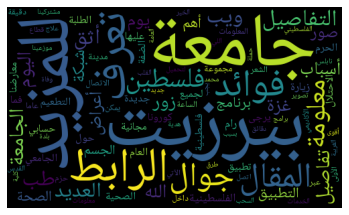

In [42]:
rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(text.split())
counts = {rtl(k):v for k, v in COUNTS.most_common(500)}
wordcloud = WordCloud(random_state=0, max_words=100,width=500, height=300,  background_color="black",font_path='NotoNaskhArabic-Regular.ttf')
wordcloud.generate_from_frequencies(counts)
plt.imshow(wordcloud, interpolation= None)
plt.axis("off")
plt.show()


### Prepare dataframe for ML

We need to prepare the data for Machine learning algorithm.

In [44]:
txtdf['classification'].replace({'sport':'الرياضة','politics_news':'السياسة ','religions':'ديانات','computer_math':'تكنولوجيا','medical':'طبي','economics':'إقتصاد','literatures_arts':'فنون'}, inplace=True)
txtdf['combined_text'] = txtdf['text']+" "+txtdf['classification']
txtdf['combined_text']

0       ورشة فنية الطباعة الزرقاء  الفنانة شذى الصفدي ...
1       حملة تعشيب وتنظيف داخل الحرم الجامعي لاستقبال ...
2       كتب خريج الجامعة المهندس وجدي مرعب  زلت أذكر ج...
3        الفعاليات الفلكية  مرصد الجامعة الفلكي مرصد م...
4       جامعة بيرزيت تفوز بدعم مشروعين  الوكالة النروي...
                              ...                        
3649    تعددت الآراء حول لقاحات كورونا المستجدة  مؤيد ...
3650    رغم أنها بذور صغيرة   قيمة بذور القرع الغذائية...
3651    العديد  التغيرات والتحولات المفاجئة  مواصفات ا...
3652     مجموعة  الأطعمة المفيدة للكلى وتلك الضارة الس...
3653    يعتبر نقص المغنيسيوم  الحالات الصحية  الشائعة ...
Name: combined_text, Length: 3604, dtype: object

In [45]:
CV_TF_IDF = TfidfVectorizer(stop_words= stop_ls,ngram_range = (1,2))
CV_TF_IDF_ = CV_TF_IDF.fit_transform(txtdf['combined_text'])
CV_TF_IDF_.shape

df_tf = pd.DataFrame(CV_TF_IDF_.toarray(),columns = CV_TF_IDF.get_feature_names())
df_tf


,آثار,آثار الحبوب,آثار السياسة,آثار جانبية,آثار قرية,آثار معلومة,آثاره,آثاره بينما,آثارها,آثارها الجانبية,...,يوميا يفوق,يومية,يومية تسبب,يونس,يونس البحري,يونس جنوب,يونيسكو,يونيسكو تنتظر,ييرود,ييرود شرق
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
